#**INITIALIZATIONS**

##**IMPORTS**

In [ ]:
# --- INSTALLS
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install jellyfish

# --- IMPORTS
import torchvision, jellyfish, warnings, scipy.io, zipfile, gensim, urllib, torch, numpy, json, math, clip, os
from scipy.stats import normaltest, shapiro, mannwhitneyu
from PIL import ImageFont, ImageDraw, Image
from IPython.display import clear_output
import matplotlib.patches as mpatches
from matplotlib import font_manager
import matplotlib.pyplot as plt
import torch.nn.functional as F
from google.colab import drive
import statistics

# --- ENVIRONMENT
drive.mount('/content/drive')
path = "drive/MyDrive/Stage_2021/"
if not os.path.exists(path) : os.mkdir(path)
if not os.path.exists(path+"FONTS") : os.mkdir(path+"FONTS")
if not os.path.exists(path+"DATA") : os.mkdir(path+"DATA")
if not os.path.exists(path+"DATASETS") : os.mkdir(path+"DATASETS")
if not os.path.exists(path+"DATASETS/LABELS") : os.mkdir(path+"DATASETS/LABELS")

# --- DOWNLOAD FONTS
urllib.request.urlretrieve ("https://www.font-police.com/classique/sans-serif/arial.ttf", path+"FONTS/arial.ttf")
url = "https://fr.ffonts.net/Lexend-Deca-Regular.font.zip"
urllib.request.urlretrieve (url, path+"FONTS/lexend_deca.zip")
with zipfile.ZipFile(path+"FONTS/lexend_deca.zip", 'r') as zip_file:
    with open(path+"FONTS/lexend_deca.ttf", 'wb') as f:
        f.write(zip_file.read('lexenddeca/LexendDeca-Regular.ttf'))

font_dirs  = [path+"FONTS"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# --- SET UP MATPLOTLIB
plt.rcParams['font.family'] = 'Lexend Deca'
plt.rc('font', size=8)                     # controls default text sizes
plt.rc('axes', titlesize=15)               # fontsize of the axes title
plt.rc('axes', labelsize=15)               # fontsize of the x and y labels
plt.rc('xtick', labelsize=9)               # fontsize of the tick labels
plt.rc('ytick', labelsize=9)               # fontsize of the tick labels
plt.rc('legend', fontsize=15)              # legend fontsize
plt.rc('figure', titlesize=12)             # fontsize of the figure title

clear_output()
warnings.filterwarnings("ignore")

##**DATASETS**

In [ ]:
# ----- STIMULIS DATASETS
if not os.path.exists(path+"DATASETS/dataset1.mat"):  urllib.request.urlretrieve ("http://wednesday.csail.mit.edu/MEG1_MEG_Clear_Data/visual_stimuli.mat", path+"DATASETS/dataset1.mat")
if not os.path.exists(path+"DATASETS/dataset2.mat"):  urllib.request.urlretrieve ("http://userpage.fu-berlin.de/rmcichy/Khaligh_Razavi_et_al_2018JoCN/118_visual_stimuli.mat", path+"DATASETS/dataset2.mat")
if not os.path.exists(path+"DATASETS/dataset3.mat"):
  urllib.request.urlretrieve ("http://wednesday.csail.mit.edu/fusion_rep/stimulus/156ImageStimuliSet.zip", path+"DATASETS/dataset3.zip")
  with zipfile.ZipFile(path+"DATASETS/dataset3.zip", 'r') as zip_file:
    with open(path+"DATASETS/dataset3.mat", 'wb') as f:
        f.write(zip_file.read('156ImageStimuliSet/visual_stimuli156.mat'))

In [ ]:
s_92  = scipy.io.loadmat(path+'/DATASETS/dataset1.mat')    # i : LABEL - HUMAN/NONHUMAN - FACE/BODY - ANIMATE/INANIMATE - NATURAL/ARTIFICIAL - PIXELS
s_118 = scipy.io.loadmat(path+'/DATASETS/dataset2.mat')    # i : LABEL - PIXELS - ANIMATE - SMALL - MEDIUM - LARGE
s_156 = scipy.io.loadmat(path+'/DATASETS/dataset3.mat')    # i : PIXELS - TWINSET - ('animals', 'objects', 'scenes', 'people', or 'faces')

images = []
for i in range(len(s_118['visual_stimuli'][0])):
  images.append(s_118['visual_stimuli'][0][i][1])
for i in range(len(s_156['visual_stimuli156'][0])):
  images.append(s_156['visual_stimuli156'][0][i][0])

##**LABELS**

* Super from MS-COCO, Basics from MS-COCO & CIFAR-100
* Remove 'person' from basics
* Replace multi-words
* Remove 's' duplicates

In [ ]:
# ----- LOAD/CREATE LABELS
if os.path.exists(path+"/DATASETS/LABELS/labels.pt") : 
  labels                     = torch.load(path+"/DATASETS/LABELS/labels.pt")
  super_labels, basic_labels, hierarchy = labels["SUPERORDINATES"], labels["BASICS"], labels["CLUSTERING"]
else:
  super_labels = set()
  basic_labels = set()

  # --- ADDING LABELS FROM MS-COCO
  if not os.path.exists("/drive/MyDrive/Stage_2021/DATASETS/LABELS/annotations.json"):
    urllib.request.urlretrieve ("http://images.cocodataset.org/annotations/annotations_trainval2017.zip", path+"DATASETS/LABELS/mscoco_annotations.zip")
    with zipfile.ZipFile(path+"DATASETS/LABELS/mscoco_annotations.zip", 'r') as zip_file:
      with open(path+"DATASETS/LABELS/annotations.json", 'wb') as f:
        f.write(zip_file.read('annotations/instances_val2017.json'))  
  with open(path+"DATASETS/LABELS/annotations.json") as an_file :
    annotations_coco = json.load(an_file)
    for labels in annotations_coco["categories"]:
      super_labels.add(labels["supercategory"])
      basic_labels.add(labels["name"])

  # --- MANUALY ADDING LABELS FROM CIFAR-100
  basic_labels.remove("person") # "person" from ms-coco should not be a basic label, as CIFAR-100 has "man","woman","boy","girl","baby"
  cifar100 = torchvision.datasets.CIFAR100(root=path+"/DATASETS/LABELS", train=False, download=True) 
  basic_labels.update(cifar100.classes)

  # --- REMOVING MULTI-WORDS AND "s" DUPLICATES
  remove_list = []

  for label in basic_labels:
    if label+"s" in basic_labels:       remove_list.append(label+"s")
    elif " " in label or "_" in label:  remove_list.append(label)

  for remove_label in remove_list:
    basic_labels.remove(remove_label)

  # --- HIERARCHY 

  hierarchy = { super:set() for super in sorted(list(super_labels)) }

  cifar_manual_clustering = {
      "outdoor":    ["bridge","castle","cloud","forest","house","mountain","orchid","plain","poppy","road","rose","sea","skyscraper","sunflower","tulip"],
      "animal":     ["bear","beaver","bee","beetle","butterfly","camel","caterpillar","cattle","chimpanzee","cockroach","crab","crocodile","dinosaur","dolphin","elephant","flatfish","fox","hamster","kangaroo","leopard","lion","lizard","lobster","mouse","otter","porcupine","possum","rabbit","raccoon","ray","seal","shark","shrew","skunk","snail","snake","spider","squirrel","tiger","trout","turtle","whale","wolf","worm"],
      "vehicle":    ["bicyle","bus","motorcycle","rocket","streetcar","tank","tractor","train"],
      "kitchen":    ["bottle","bowl","can","cup","plate"],
      "electronic": ["clock","keyboard","lamp","telephone","television"],
      "person":     ["baby","boy","girl","man","woman"],
      "food":       ["apple","mushroom","orange","pear"],
      "furniture":  ["bed","chair","couch","table","wardrobe"]
  }

  for basic_label in basic_labels :
    basic_in_hierarchy = False 

    for labels in annotations_coco["categories"]:
      if basic_label == labels["name"] :
        hierarchy[labels["supercategory"]].add(basic_label)
        basic_in_hierarchy = True 

    if not basic_in_hierarchy :
      for category in cifar_manual_clustering :
        if basic_label in cifar_manual_clustering[category]:
          hierarchy[category].add(basic_label)
          basic_in_hierarchy = True 

    assert(basic_in_hierarchy)

  # --- SAVE LABELS
  super_labels = list(hierarchy.keys())
  basic_labels = []

  for key in hierarchy:
    for basic_label in hierarchy[key]:
      basic_labels.append(basic_label)

  torch.save({"SUPERORDINATES":super_labels, "BASICS":basic_labels, "CLUSTERING":hierarchy},path+"/DATASETS/LABELS/labels.pt")

##**CLIP MODEL**

In [ ]:
device            = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
#model, preprocess = clip.load("RN50x16", device=device, jit=False)
#model, preprocess = clip.load("RN101", device=device, jit=False)
#model, preprocess = clip.load("ViT-B/16", device=device, jit=False)
#model, preprocess = clip.load("RN50x4", device=device, jit=False)
#model, preprocess = clip.load("RN50", device=device, jit=False)

text_super = clip.tokenize(["a photo of a "+label for label in super_labels]).to(device)
text_basic = clip.tokenize(["a photo of a "+label for label in basic_labels]).to(device)

# **Classification for word-superimposed images**


## **UTILS**

In [ ]:
def get_stimuli(i,preprocess=None,word=None,raw=False):
  img = Image.fromarray(images[i])
  img.show()
  # --- ADD WORD TO STIMULI
  if None is not word :
    img_width, img_height   = img.size
    fontsize                = math.floor(img_width/6)
    font                    = ImageFont.truetype(path+"/FONTS/arial.ttf", fontsize)
    text_width, text_height = font.getsize(word)
    x,y                     = img_width/2  - text_width/2, img_height/2 - text_height/2
    draw                    = ImageDraw.Draw(img)
    draw.text((x,y),word,(255,0,0),font=font,stroke_width=math.ceil(fontsize/20),stroke_fill=(255,255,255))

  # --- APPLY PREPROCESSING
  if None is not preprocess : return preprocess(img)
  elif not raw :              return torch.tensor(numpy.array(img))
  else :                      return img

def get_stimulis(a,b,preprocess=None,word=None):
    return torch.cat(([get_stimuli(i,preprocess=preprocess,word=word).unsqueeze(0) for i in range(a,b)]))

In [ ]:
def compute_original_preds(batch_size=128):
  data_path    = path+"/DATA/"+model_name+"_"+"context"+str(contexts.index(context))+"_original_preds.pt"
  dataset_size = 274

  # ----- CHECKING IF DATA ALREADY EXISTS -------------------------------------------
  if os.path.exists(data_path): original_predictions = torch.load(data_path,map_location=device)
  else:                         
    original_predictions = {}
    # ---- PROCESSING DATA IN MINI-BATCHES --------------------------------
    for i in range(0,math.ceil(dataset_size/batch_size)):
      a,b    = i*batch_size, min(dataset_size,i*batch_size + batch_size)
      batch  = get_stimulis(a,b,preprocess).to(device)

      # --- BASIC PREDICTIONS ------------------------------------------
      with torch.no_grad():
          logits_per_image_basic, _  = model(batch, text_basic)
          probs_basic                = logits_per_image_basic.softmax(dim=-1)
          _, preds_basic             = torch.max(probs_basic,1)

      # --- SUPERORDINATE PREDICTIONS ----------------------------------
      with torch.no_grad():
          logits_per_image_super, _  = model(batch, text_super)
          probs_super                = logits_per_image_super.softmax(dim=-1)
          _, preds_super             = torch.max(probs_super,1)
          
      # --- SAVING PREDICTIONS -------------------------------------------
      for j in range(a,b):
        result = {"Superordinate":{},"Basic":{}}

        result["Superordinate"]["Prediction"]   = preds_super[j-a]
        result["Superordinate"]["Logits"]       = logits_per_image_super[j-a]
        result["Superordinate"]["Probas"]       = probs_super[j-a]

        result["Basic"]["Prediction"]           = preds_basic[j-a]
        result["Basic"]["Logits"]               = logits_per_image_basic[j-a]
        result["Basic"]["Probas"]               = probs_basic[j-a]

        original_predictions[j] = result
        
    torch.save(original_predictions,data_path)
  return original_predictions

In [ ]:
def get_original_preds(i,display=False):
  data = original_predictions[i]

  super_pred = data["Superordinate"]["Prediction"]
  super_logit = data["Superordinate"]["Logits"][super_pred]
  super_proba = data["Superordinate"]["Probas"][super_pred]

  basic_pred = data["Basic"]["Prediction"]
  basic_logit = data["Basic"]["Logits"][basic_pred]
  basic_proba = data["Basic"]["Probas"][basic_pred]

  if display :
    stimuli = get_stimuli(i)
    plt.imshow(stimuli.cpu())
    plt.show()
    print(f"SUPERORDINATE LABEL \t: {super_labels[super_pred]} | {super_proba*100}%")
    print(f"BASIC LABEL \t\t: {basic_labels[basic_pred]} | {basic_proba*100}%")

  return data

In [ ]:
def compute_new_preds(batch_size=128):
  data_path    = path+"/DATA/"+model_name+"_"+"context"+str(contexts.index(context))+"_wordsAdd_preds.pt"
  dataset_size = 274
  words        = list(set(super_labels) | set(basic_labels))

  print(len(words))

  # ----- CHECKING IF DATA ALREADY EXISTS -------------------------------------------
  if os.path.exists(data_path): wordsAdd_predictions = torch.load(data_path,map_location=device)
  else:                         wordsAdd_predictions = {}
  start = len(wordsAdd_predictions.keys())  # Start at where we're at

  # ----- COLLECTING THE PREDICTIONS FOR EACH WORD-IMAGE PAIRS -------------------
  for w in range(start,len(words)) :
    word                       = words[w]
    wordsAdd_predictions[word] = []
    clear_output()
    print(word)
    print(f"{w+1}/{len(words)}")

    # ---- PROCESSING DATA IN MINI-BATCHES --------------------------------
    for i in range(0,math.ceil(dataset_size/batch_size)):
      a,b    = i*batch_size, min(dataset_size,i*batch_size + batch_size)
      images = get_stimulis(a,b,preprocess,word).to(device)

      # --- BASIC PREDICTIONS ------------------------------------------
      with torch.no_grad():
          logits_per_image_basic, _  = model(images, text_basic)
          probs_basic          = logits_per_image_basic.softmax(dim=-1)
          _, preds_basic       = torch.max(probs_basic,1)

      # --- SUPERORDINATE PREDICTIONS ----------------------------------
      with torch.no_grad():
          logits_per_image_super, _  = model(images, text_super)
          probs_super          = logits_per_image_super.softmax(dim=-1)
          _, preds_super       = torch.max(probs_super,1)

      # --- SAVING PREDICTIONS -------------------------------------------
      for j in range(a,b):
        result = {"Superordinate":{},"Basic":{}}

        result["Superordinate"]["Prediction"]           = preds_super[j-a]
        result["Superordinate"]["Logits"]               = logits_per_image_super[j-a]
        result["Superordinate"]["Probas"]               = probs_super[j-a]

        result["Basic"]["Prediction"]                   = preds_basic[j-a]
        result["Basic"]["Logits"]                       = logits_per_image_basic[j-a]
        result["Basic"]["Probas"]                       = probs_basic[j-a]

        wordsAdd_predictions[word].append(result)

  torch.save(wordsAdd_predictions,data_path)
  return wordsAdd_predictions

In [ ]:
def get_wordAdd_preds(i,word,display=False):

  data    = wordsAdd_predictions[word][i]
  og_data = get_original_preds(i)

  if display :
    og_super_pred     = og_data["Superordinate"]["Prediction"]
    og_super_logit    = og_data["Superordinate"]["Logits"][og_super_pred]
    og_super_proba    = og_data["Superordinate"]["Probas"][og_super_pred]

    super_pred     = data["Superordinate"]["Prediction"]
    super_logit    = data["Superordinate"]["Logits"][super_pred]
    super_proba    = data["Superordinate"]["Probas"][super_pred]
    
    og_super_newLogit = data["Superordinate"]["Logits"][og_super_pred]
    og_super_newProba = data["Superordinate"]["Probas"][og_super_pred]

    # --------------------------------------------------------------

    og_basic_pred     = og_data["Basic"]["Prediction"]
    og_basic_logit    = og_data["Basic"]["Logits"][og_basic_pred]
    og_basic_proba    = og_data["Basic"]["Probas"][og_basic_pred]

    basic_pred     = data["Basic"]["Prediction"]
    basic_logit    = data["Basic"]["Logits"][basic_pred]
    basic_proba    = data["Basic"]["Probas"][basic_pred]
    
    og_basic_newLogit = data["Basic"]["Logits"][og_basic_pred]
    og_basic_newProba = data["Basic"]["Probas"][og_basic_pred]

    stimuli = get_stimuli(i,preprocess=None,word=word)
    plt.imshow(stimuli.cpu())
    plt.show()

    print(f"SUPERORDINATE \t NEW \t\t: {super_labels[super_pred]} | {super_proba*100}%")
    print(f"\t\t ORIGINAL \t: {super_labels[og_super_pred]} | {og_super_proba*100}% --> {og_super_newProba*100}%")
    print("----------------------------------------------------------------------------------------------------------------------------------------")
    print(f"BASIC \t\t NEW \t\t: {basic_labels[basic_pred]} | {basic_proba*100}%")
    print(f"\t\t ORIGINAL \t: {basic_labels[og_basic_pred]} | {og_basic_proba*100}% --> {og_basic_newProba*100}%")

  return data

In [ ]:
if not os.path.exists(path+"DATASETS/GoogleNews-vectors-negative300.bin"):  
    urllib.request.urlretrieve ("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", path+"DATASETS/GoogleNews-vectors-negative300.bin.gz")
    !gunzip "drive/MyDrive/Stage_2021/DATASETS/GoogleNews-vectors-negative300.bin.gz"
model_w2v = gensim.models.KeyedVectors.load_word2vec_format(path+"DATASETS/GoogleNews-vectors-negative300.bin", binary=True)  

def semantic_similarity_w2v(w1,w2):
  f1, f2 = torch.tensor(model_w2v[w1]), torch.tensor(model_w2v[w2])
  return torch.nn.CosineSimilarity(dim=0)(f1,f2).item()

In [ ]:
def get_EWA():
  miss_rates = {"Superordinate":{},"Basic":{}}
  miss_rates["Superordinate"]["Superordinate"] = 0.0
  miss_rates["Basic"]["Superordinate"]         = 0.0
  miss_rates["Superordinate"]["Basic"]         = 0.0
  miss_rates["Basic"]["Basic"]                 = 0.0

  # ----- SUPERORDINATE WA ------------------------------------------------------------------------------------------------------------------------
  counted_basic = 0
  counted_super = 0
  for wa in super_labels:
    for i in range(0,274):
      original_preds, new_preds = get_original_preds(i), get_wordAdd_preds(i,wa)
      if (wa != super_labels[original_preds["Superordinate"]["Prediction"]]):
        miss_rates["Superordinate"]["Superordinate"] += (original_preds["Superordinate"]["Prediction"].item() != new_preds["Superordinate"]["Prediction"].item())
        miss_rates["Basic"]["Superordinate"]         += (original_preds["Basic"]["Prediction"].item()         != new_preds["Basic"]["Prediction"].item())
        counted_super += 1
      
  miss_rates["Superordinate"]["Superordinate"] /= counted_super
  miss_rates["Basic"]["Superordinate"]         /= counted_super

  # ----- BASIC WA --------------------------------------------------------------------------------------------------------------------------------
  counted_basic = 0
  for wa in basic_labels:
    for i in range(0,274):
      original_preds, new_preds = get_original_preds(i), get_wordAdd_preds(i,wa)
      if (wa != basic_labels[original_preds["Basic"]["Prediction"]]):
        miss_rates["Basic"]["Basic"]         += (original_preds["Basic"]["Prediction"].item()         != new_preds["Basic"]["Prediction"].item())
        miss_rates["Superordinate"]["Basic"] += (original_preds["Superordinate"]["Prediction"].item() != new_preds["Superordinate"]["Prediction"].item())
        counted_basic += 1
        
  miss_rates["Superordinate"]["Basic"] /= counted_basic
  miss_rates["Basic"]["Basic"]         /= counted_basic

  return miss_rates

In [ ]:
def get_word_correlation_references(metric):
  references = {"Superordinate":{},"Basic":{}}
  references["Superordinate"]["Superordinate"] = []
  references["Basic"]["Superordinate"]         = []
  references["Superordinate"]["Basic"]         = []
  references["Basic"]["Basic"]                 = [] 

  for pred_category in ["Basic","Superordinate"]:
    for wa_category in ["Basic","Superordinate"]:
      added_words = (super_labels if wa_category=="Superordinate" else basic_labels)
      labels      = (super_labels if pred_category=="Superordinate" else basic_labels)

      similarities   = []
      for wa in added_words:
        for i in range(0,274):
          original_data   = get_original_preds(i)
          original_pred   = original_data[pred_category]["Prediction"]
          original_label  = labels[original_pred]

          #print(wa)
          similarities.append(metric(wa,original_label))
      
      references[pred_category][wa_category] = similarities

  return references

In [ ]:
def get_word_correlation_references_nonswitchonly(metric):
  references = {"Superordinate":{},"Basic":{}}
  references["Superordinate"]["Superordinate"] = []
  references["Basic"]["Superordinate"]         = []
  references["Superordinate"]["Basic"]         = []
  references["Basic"]["Basic"]                 = [] 

  for pred_category in ["Basic","Superordinate"]:
    for wa_category in ["Basic","Superordinate"]:
      added_words = (super_labels if wa_category=="Superordinate" else basic_labels)
      labels      = (super_labels if pred_category=="Superordinate" else basic_labels)

      similarities   = []
      for wa in added_words:
        for i in range(0,274):
          original_data, new_data   = get_original_preds(i), get_wordAdd_preds(i,wa)
          original_pred, new_pred   = original_data[pred_category]["Prediction"], new_data[pred_category]["Prediction"]
          original_label, new_label = labels[original_pred], labels[new_pred]

          if original_pred == new_pred:
            similarities.append(metric(wa,original_label))

      references[pred_category][wa_category] = similarities


  return references

In [ ]:
def get_OAC(metric):
  references = {"Superordinate":{},"Basic":{}}
  references["Superordinate"]["Superordinate"] = []
  references["Basic"]["Superordinate"]         = []
  references["Superordinate"]["Basic"]         = []
  references["Basic"]["Basic"]                 = [] 

  for pred_category in ["Basic","Superordinate"]:
    for wa_category in ["Basic","Superordinate"]:
      added_words = (super_labels if wa_category=="Superordinate" else basic_labels)
      labels      = (super_labels if pred_category=="Superordinate" else basic_labels)

      similarities   = []
      for wa in added_words:
        for i in range(0,274):
          original_data, new_data   = get_original_preds(i), get_wordAdd_preds(i,wa)
          original_pred, new_pred   = original_data[pred_category]["Prediction"], new_data[pred_category]["Prediction"]
          original_label, new_label = labels[original_pred], labels[new_pred]

          if original_pred != new_pred:
            similarities.append(metric(wa,original_label))

      references[pred_category][wa_category] = similarities


  return references

In [ ]:
def get_NAC(metric):
  references = {"Superordinate":{},"Basic":{}}
  references["Superordinate"]["Superordinate"] = []
  references["Basic"]["Superordinate"]         = []
  references["Superordinate"]["Basic"]         = []
  references["Basic"]["Basic"]                 = [] 

  for pred_category in ["Basic","Superordinate"]:
    for wa_category in ["Basic","Superordinate"]:
      added_words = (super_labels if wa_category=="Superordinate" else basic_labels)
      labels      = (super_labels if pred_category=="Superordinate" else basic_labels)

      similarities   = []
      for wa in added_words:
        for i in range(0,274):
          original_data, new_data   = get_original_preds(i), get_wordAdd_preds(i,wa)
          original_pred, new_pred   = original_data[pred_category]["Prediction"], new_data[pred_category]["Prediction"]
          original_label, new_label = labels[original_pred], labels[new_pred]

          if original_pred != new_pred:
            similarities.append(metric(wa,new_label))

      references[pred_category][wa_category] = similarities

  return references

In [ ]:
def get_probabilities_references():
  references = {"Basic":[],"Superordinate":[]}

  for i in range(0,274):
    original_preds         = get_original_preds(i)
    super_pred, basic_pred = original_preds["Superordinate"]["Prediction"], original_preds["Basic"]["Prediction"]
    references["Superordinate"].append(original_preds["Superordinate"]["Probas"][super_pred].item())
    references["Basic"].append(original_preds["Basic"]["Probas"][basic_pred].item())

  return references

In [ ]:
def get_probabilities_references_nonswitched():
  original_probs = {"Superordinate":{},"Basic":{}}
  original_probs["Superordinate"]["Superordinate"] = []
  original_probs["Basic"]["Superordinate"]         = []
  original_probs["Superordinate"]["Basic"]         = []
  original_probs["Basic"]["Basic"]                 = []  

  # ----- SUPERORDINATE WA -------------------------------------------------------------------------------------------------
  for wa in super_labels:
    for i in range(0,274):
      original_preds, new_preds = get_original_preds(i), get_wordAdd_preds(i,wa)

      # --- SUPERORDINATE PRED
      originalPred, newPred = original_preds["Superordinate"]["Prediction"], new_preds["Superordinate"]["Prediction"]
      if originalPred == newPred :
        original_probs["Superordinate"]["Superordinate"].append(original_preds["Superordinate"]["Probas"][originalPred].item())

      # --- BASIC PRED
      originalPred, newPred = original_preds["Basic"]["Prediction"], new_preds["Basic"]["Prediction"]
      if originalPred == newPred :
        original_probs["Basic"]["Superordinate"].append(original_preds["Basic"]["Probas"][originalPred].item())

  # ----- BASIC WA --------------------------------------------------------------------------------------------------------
  for wa in basic_labels:
    for i in range(0,274):
      original_preds, new_preds = get_original_preds(i), get_wordAdd_preds(i,wa)

      # --- SUPERORDINATE PRED
      originalPred, newPred = original_preds["Superordinate"]["Prediction"], new_preds["Superordinate"]["Prediction"]
      if originalPred == newPred :
        original_probs["Superordinate"]["Basic"].append(original_preds["Superordinate"]["Probas"][originalPred].item())

      # --- BASIC PRED
      originalPred, newPred = original_preds["Basic"]["Prediction"], new_preds["Basic"]["Prediction"]
      if originalPred == newPred :
        original_probs["Basic"]["Basic"].append(original_preds["Basic"]["Probas"][originalPred].item())


  return original_probs

In [ ]:
def get_COM_original():
  original_probs = {"Superordinate":{},"Basic":{}}
  original_probs["Superordinate"]["Superordinate"] = []
  original_probs["Basic"]["Superordinate"]         = []
  original_probs["Superordinate"]["Basic"]         = []
  original_probs["Basic"]["Basic"]                 = []  

  # ----- SUPERORDINATE WA -------------------------------------------------------------------------------------------------
  for wa in super_labels:
    for i in range(0,274):
      original_preds, new_preds = get_original_preds(i), get_wordAdd_preds(i,wa)

      # --- SUPERORDINATE PRED
      originalPred, newPred = original_preds["Superordinate"]["Prediction"], new_preds["Superordinate"]["Prediction"]
      if originalPred != newPred :
        original_probs["Superordinate"]["Superordinate"].append(original_preds["Superordinate"]["Probas"][originalPred].item())

      # --- BASIC PRED
      originalPred, newPred = original_preds["Basic"]["Prediction"], new_preds["Basic"]["Prediction"]
      if originalPred != newPred :
        original_probs["Basic"]["Superordinate"].append(original_preds["Basic"]["Probas"][originalPred].item())

  # ----- BASIC WA --------------------------------------------------------------------------------------------------------
  for wa in basic_labels:
    for i in range(0,274):
      original_preds, new_preds = get_original_preds(i), get_wordAdd_preds(i,wa)

      # --- SUPERORDINATE PRED
      originalPred, newPred = original_preds["Superordinate"]["Prediction"], new_preds["Superordinate"]["Prediction"]
      if originalPred != newPred :
        original_probs["Superordinate"]["Basic"].append(original_preds["Superordinate"]["Probas"][originalPred].item())

      # --- BASIC PRED
      originalPred, newPred = original_preds["Basic"]["Prediction"], new_preds["Basic"]["Prediction"]
      if originalPred != newPred :
        original_probs["Basic"]["Basic"].append(original_preds["Basic"]["Probas"][originalPred].item())


  return original_probs

In [ ]:
def get_COM_new():
  new_probs = {"Superordinate":{},"Basic":{}}
  new_probs["Superordinate"]["Superordinate"] = []
  new_probs["Basic"]["Superordinate"]         = []
  new_probs["Superordinate"]["Basic"]         = []
  new_probs["Basic"]["Basic"]                 = []  

  # ----- SUPERORDINATE WA -------------------------------------------------------------------------------------------------
  for wa in super_labels:
    for i in range(0,274):
      original_preds, new_preds = get_original_preds(i), get_wordAdd_preds(i,wa)

      # --- SUPERORDINATE PRED
      originalPred, newPred = original_preds["Superordinate"]["Prediction"], new_preds["Superordinate"]["Prediction"]
      if originalPred != newPred :
        new_probs["Superordinate"]["Superordinate"].append(new_preds["Superordinate"]["Probas"][newPred].item())

      # --- BASIC PRED
      originalPred, newPred = original_preds["Basic"]["Prediction"], new_preds["Basic"]["Prediction"]
      if originalPred != newPred :
        new_probs["Basic"]["Superordinate"].append(new_preds["Basic"]["Probas"][newPred].item())

  # ----- BASIC WA --------------------------------------------------------------------------------------------------------
  for wa in basic_labels:
    for i in range(0,274):
      original_preds, new_preds = get_original_preds(i), get_wordAdd_preds(i,wa)

      # --- SUPERORDINATE PRED
      originalPred, newPred = original_preds["Superordinate"]["Prediction"], new_preds["Superordinate"]["Prediction"]
      if originalPred != newPred :
        new_probs["Superordinate"]["Basic"].append(new_preds["Superordinate"]["Probas"][newPred].item())

      # --- BASIC PRED
      originalPred, newPred = original_preds["Basic"]["Prediction"], new_preds["Basic"]["Prediction"]
      if originalPred != newPred :
        new_probs["Basic"]["Basic"].append(new_preds["Basic"]["Probas"][newPred].item())


  return new_probs

In [ ]:
def get_COM_neworiginal():
  new_probs = {"Superordinate":{},"Basic":{}}
  new_probs["Superordinate"]["Superordinate"] = []
  new_probs["Basic"]["Superordinate"]         = []
  new_probs["Superordinate"]["Basic"]         = []
  new_probs["Basic"]["Basic"]                 = []  

  # ----- SUPERORDINATE WA -------------------------------------------------------------------------------------------------
  for wa in super_labels:
    for i in range(0,274):
      original_preds, new_preds = get_original_preds(i), get_wordAdd_preds(i,wa)

      # --- SUPERORDINATE PRED
      originalPred, newPred = original_preds["Superordinate"]["Prediction"], new_preds["Superordinate"]["Prediction"]
      if originalPred != newPred :
        new_probs["Superordinate"]["Superordinate"].append(new_preds["Superordinate"]["Probas"][originalPred].item())

      # --- BASIC PRED
      originalPred, newPred = original_preds["Basic"]["Prediction"], new_preds["Basic"]["Prediction"]
      if originalPred != newPred :
        new_probs["Basic"]["Superordinate"].append(new_preds["Basic"]["Probas"][originalPred].item())

  # ----- BASIC WA --------------------------------------------------------------------------------------------------------
  for wa in basic_labels:
    for i in range(0,274):
      original_preds, new_preds = get_original_preds(i), get_wordAdd_preds(i,wa)

      # --- SUPERORDINATE PRED
      originalPred, newPred = original_preds["Superordinate"]["Prediction"], new_preds["Superordinate"]["Prediction"]
      if originalPred != newPred :
        new_probs["Superordinate"]["Basic"].append(new_preds["Superordinate"]["Probas"][originalPred].item())

      # --- BASIC PRED
      originalPred, newPred = original_preds["Basic"]["Prediction"], new_preds["Basic"]["Prediction"]
      if originalPred != newPred :
        new_probs["Basic"]["Basic"].append(new_preds["Basic"]["Probas"][originalPred].item())


  return new_probs

In [ ]:
def display_test_boxplots(REF,O,N,testCategory,distNames):
  fig, axs = plt.subplots(2, 2, figsize=(12,10))
  i,j = 0,0
  for pred_category in ["Superordinate", "Basic"]:
    for wa_category in ["Superordinate", "Basic"]:
      box_ref  = display_boxes(axs[i][j],[REF[pred_category][wa_category] if testCategory!="PROBABILITY" else REF[pred_category], [], []],[distNames[0],distNames[1],distNames[2]],"",testCategory,"",(-0.1,1.1))
      box_oac  = display_boxes(axs[i][j],[[], O[pred_category][wa_category],[]],[distNames[0],distNames[1],distNames[2]],"",testCategory,"",(-0.1,1.1))
      box_nac  = display_boxes(axs[i][j],[[], [],N[pred_category][wa_category]],[distNames[0],distNames[1],distNames[2]],"",testCategory,"",(-0.1,1.1))
      axs[i][j].set_title(f"{pred_category.upper()} LABELS | {wa_category.upper()} wa")

      set_box_colors(box_ref,["white","black","black","black"])
      set_box_colors(box_oac,["black","green","green","green"])
      set_box_colors(box_nac,["black","red","red","red"])
      j+=1 
    i+=1
    j=0

  fig.subplots_adjust(wspace=0.25, hspace=0.3)

In [ ]:
def display_test_boxplots_twoconds(REF,O,testCategory,distNames):
  #I changed the order of panels (pred_category and wa_category)to make consistency in the paper 
  fig, axs = plt.subplots(2, 2, figsize=(12,10))
  i,j = 0,0
  for wa_category in ["Superordinate", "Basic"]:
    for pred_category in ["Superordinate", "Basic"]:
      #exclude the same category between images and words
      tmp = REF[pred_category][wa_category] if testCategory!="PROBABILITY" else REF[pred_category]
      tmp = [i for i in tmp if i != 1.0]
      tmp = [tmp,[]]
      box_ref  = display_boxes_forpaper(axs[i][j],tmp,[distNames[0],distNames[1]],"",testCategory,"",(-0.1,1.1))
      box_oac  = display_boxes_forpaper(axs[i][j],[[], O[pred_category][wa_category]],[distNames[0],distNames[1]],"",testCategory,"",(-0.1,1.1))
      #axs[i][j].set_title(f"{pred_category.upper()} LABELS | {wa_category.upper()} ew")

      #save_csv_two(REF[pred_category][wa_category] if testCategory!="PROBABILITY" else REF[pred_category],O[pred_category][wa_category],pred_category,wa_category,testCategory)

      set_box_colors(box_ref,["white","black","black","black"])
      set_box_colors(box_oac,["black","red","red","red"])
      j+=1 
    i+=1
    j=0

  fig.subplots_adjust(wspace=0.25, hspace=0.3)

In [ ]:
def display_test_boxplots_fourconds(REF,O,ON,N,testCategory,distNames):
  #I changed the order of panels (pred_category and wa_category)to make consistency in the paper 
  fig, axs = plt.subplots(2, 2, figsize=(24,10))
  i,j = 0,0
  for wa_category in ["Superordinate", "Basic"]:
    for pred_category in ["Superordinate", "Basic"]:
      #exclude the same category between images and words
      tmp = [REF[pred_category][wa_category],[],[],[]]
      #tmp = [i for i in tmp if i != 1.0]
      #tmp = [tmp,[]]
      box_ref  = display_boxes_forpaper(axs[i][j],tmp,[distNames[0],distNames[1],distNames[2],distNames[3]],"",testCategory,"",(-0.1,1.1))
      box_switchedoriginal  = display_boxes_forpaper(axs[i][j],[[], O[pred_category][wa_category],[],[]],[distNames[0],distNames[1],distNames[2],distNames[3]],"",testCategory,"",(-0.1,1.1))
      box_oridinalnew  = display_boxes_forpaper(axs[i][j],[[],[], ON[pred_category][wa_category],[]],[distNames[0],distNames[1],distNames[2],distNames[3]],"",testCategory,"",(-0.1,1.1))
      box_newlabel  = display_boxes_forpaper(axs[i][j],[[],[],[], N[pred_category][wa_category]],[distNames[0],distNames[1],distNames[2],distNames[3]],"",testCategory,"",(-0.1,1.1))
      #axs[i][j].set_title(f"{pred_category.upper()} LABELS | {wa_category.upper()} ew")

      #save_csv_four(REF[pred_category][wa_category],O[pred_category][wa_category],ON[pred_category][wa_category],N[pred_category][wa_category],pred_category,wa_category,testCategory)

      set_box_colors(box_ref,["white","black","black","black"])
      set_box_colors(box_switchedoriginal,["black","red","red","red"])
      set_box_colors(box_oridinalnew,["black","red","red","red"])
      set_box_colors(box_newlabel,["black","blue","blue","blue"])
      j+=1 
    i+=1
    j=0

  fig.subplots_adjust(wspace=0.25, hspace=0.3)

In [ ]:
def save_csv_four(REF,O,ON,N,pred_category,wa_category,testtCategory):
    import pandas as pd
    df = pd.DataFrame(REF,
                  columns=['unswitch'])
    df['labelswitched'] = O
    df['original_label'] = ON
    df['new_label'] = N
    df.to_csv(path+testCategory+pred_category+wa_category+'.csv')


In [ ]:
def save_csv_two(REF,O,pred_category,wa_category,testtCategory):
    import pandas as pd
    df = pd.DataFrame(REF,
                  columns=['unswitch'])
    df['labelswitched'] = O
    df.to_csv(path+testCategory+pred_category+wa_category+'.csv')

In [ ]:
def display_boxes_forpaper(ax,data,tickLabels,xlabel,ylabel,title,yscale):
  boxes = ax.boxplot(data,showfliers=True,patch_artist=True,widths=0.5)
  ax.set_ylabel(ylabel,labelpad=20)
  ax.set_xlabel(xlabel,labelpad=20)
  ax.set_xticklabels(tickLabels,fontsize=20)
  ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
  ax.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'],fontsize=18)
  ax.set_title(title)
  ax.set_ylim(yscale)
  #ax.spines['top'].set_visible(False)
  #ax.spines['right'].set_visible(False)
  #plt.tight_layout()

  return boxes

In [ ]:
def display_test_histograms(REF,O,N,testCategory,distNames,bins):
  fig, axs = plt.subplots(2, 2, figsize=(15,10))
  i,j = 0,0
  for pred_category in ["Superordinate", "Basic"]:
    for wa_category in ["Superordinate", "Basic"]:
      axs[i][j].set_title(f"{pred_category.upper()} LABELS | {wa_category.upper()} wa")
      axs[i][j].set_xlabel(testCategory)
      axs[i][j].hist(REF[pred_category][wa_category] if testCategory!="PROBABILITY" else REF[pred_category],bins=bins,color="black",alpha = 1,density=True,label=distNames[0])
      axs[i][j].hist(O[pred_category][wa_category],bins=bins,color="green",alpha = 0.7,density=True,label=distNames[1])
      axs[i][j].hist(N[pred_category][wa_category],bins=bins,color="red",alpha = 0.7,density=True,label=distNames[2])
      axs[i][j].set_ylabel("%")

      if (i,j) == (1,1):
        handles, labels = axs[i][j].get_legend_handles_labels()
      j+=1 
    i+=1
    j=0

  fig.legend(handles, labels, loc = (0.91, 0.828))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)

In [ ]:
def dist_comparison(REF,O,N,distNames,probas=False):
  for pred_category in ["Superordinate","Basic"]:
    for wa_category in ["Superordinate","Basic"]:

      print("\n---")
      print(f"{pred_category.upper()} LABELS | {wa_category.upper()} wa")

      # --- REF / O
      u,p = mannwhitneyu(REF[pred_category][wa_category] if not probas else REF[pred_category],O[pred_category][wa_category],alternative="two-sided")
      m1, m2 = statistics.median(REF[pred_category][wa_category] if not probas else REF[pred_category]), statistics.median(O[pred_category][wa_category])
      res = ""
      if p < 0.05:
        res = distNames[0]+" STATISTICALLY DIFFERENT FROM "+distNames[1]+" | "
        if m1 < m2   : res += distNames[0]+" < "+distNames[1]
        elif m1 > m2 : res += distNames[0]+" > "+distNames[1]
      else:
        res = distNames[0]+" NOT SIGNIFICANTLY DIFFERENT FROM "+distNames[1]
      print(res+" | u = "+str(u)+",\t\t p = "+str(p))

      # --- REF / N
      u,p = mannwhitneyu(REF[pred_category][wa_category] if not probas else REF[pred_category],N[pred_category][wa_category],alternative="two-sided")
      m1, m2 = statistics.median(REF[pred_category][wa_category] if not probas else REF[pred_category]), statistics.median(N[pred_category][wa_category])
      res = ""
      if p < 0.05:
        res = distNames[0]+" STATISTICALLY DIFFERENT FROM "+distNames[2]+" | "
        if m1 < m2   : res += distNames[0]+" < "+distNames[2]
        elif m1 > m2 : res += distNames[0]+" > "+distNames[2]
      else:
        res = distNames[0]+" NOT SIGNIFICANTLY DIFFERENT FROM "+distNames[2]
      print(res+" | u = "+str(u)+",\t\t p = "+str(p))


      # --- O / N
      u,p = mannwhitneyu(O[pred_category][wa_category],N[pred_category][wa_category],alternative="two-sided")
      m1, m2 = statistics.median(O[pred_category][wa_category]), statistics.median(N[pred_category][wa_category])
      res = ""
      if p < 0.05:
        res = distNames[1]+" STATISTICALLY DIFFERENT FROM "+distNames[2]+" | "
        if m1 < m2   : res += distNames[1]+" < "+distNames[2]
        elif m1 > m2 : res += distNames[1]+" > "+distNames[2]
      else:
        res = distNames[1]+" NOT SIGNIFICANTLY DIFFERENT FROM "+distNames[2]
      print(res+" | u = "+str(u)+",\t\t p = "+str(p))


In [ ]:
def visual_normalityCheck(REF):
  fig, axs = plt.subplots(2, 2, figsize=(15,10))
  i,j = 0,0

  for pred_category in ["Superordinate", "Basic"]:
    for wa_category in ["Superordinate", "Basic"]:
      scipy.stats.probplot(REF[pred_category][wa_category] if testCategory!="PROBABILITY" else REF[pred_category], dist="norm", plot=axs[i][j])
      axs[i][j].set_title(f"{pred_category.upper()} LABELS | {wa_category.upper()} wa")

      j+=1
    i+=1
    j=0

  fig.subplots_adjust(wspace=0.3, hspace=0.3)

In [ ]:
def numerical_normalityCheck(REF,method):
  print("USING "+("Shapiro-Wilk Test" if method=="Shapiro" else "D’Agostino’s K² Test"))
  for pred_category in ["Superordinate", "Basic"]:
    for wa_category in ["Superordinate", "Basic"]:
      print("---")
      print(f"REF FOR : {pred_category.upper()} LABELS | {wa_category.upper()} wa")
      if method=="Shapiro":
        _, p1 = shapiro(REF[pred_category][wa_category] if testCategory!="PROBABILITY" else REF[pred_category])
        print(("  NOT NORMAL " if p1 < 0.05 else ("NORMAL     ")) + "\t p = " + str(p1))
      else:
        _, p2 = normaltest(REF[pred_category][wa_category] if testCategory!="PROBABILITY" else REF[pred_category])
        print(("  NOT NORMAL " if p2 < 0.05 else ("NORMAL     ")) + "\t p = " + str(p2))

In [ ]:
def display_boxes(ax,data,tickLabels,xlabel,ylabel,title,yscale):
  boxes = ax.boxplot(data,showfliers=False,patch_artist=True)
  ax.set_ylabel(ylabel,labelpad=15)
  ax.set_xlabel(xlabel,labelpad=15)
  ax.set_xticklabels(tickLabels,fontsize=15)
  ax.set_title(title)
  ax.set_ylim(yscale)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  plt.tight_layout()

  return boxes

In [ ]:
def set_box_colors(box,colors):
  for element in box['medians']:
      element.set_color(colors[0])
      element.set_linewidth(2)
  for element in box['boxes']:
      element.set_facecolor(colors[1])
      element.set_linewidth(2)
  for element in box['whiskers']:
      element.set_linewidth(2)
  for element in box['caps']:
      element.set_linewidth(2)

## **BENCHMARK TEST**

In [ ]:
# ----- INITIALIZATIONS -------------------------------------------------------------------------------------------------
model_name    = "clip"           # Name of the model
#model_name    = "clip_res5016"           # Name of the model
#model_name    = "clip_RN101"
#model_name    = "clip_ViT-B16"
#model_name    = "clip_RN50x4"
#model_name    = "clip_RN50"
model         = model            # Model
preprocess_fn = preprocess       # Preprocessing to be applied on raw images
tokenize_fn   = clip.tokenize    # Tokenize function
images        = images           # Dataset of test images
labels        = hierarchy        # Basic labels clustered by superordinate category
#contexts      = ["a photo of a ", "a text that says "]
contexts      = ["a photo of a "]
dataset_size = 274
# ------------------------------------------------------------------------------------------------------------------------

In [ ]:
  if not os.path.exists(path+"/DATA/"+model_name+"_benchmark_results.pt"):
    results = {context:{} for context in contexts}
    super_labels = [super_label for super_label in labels]
    basic_labels = sorted(sum([[basic_label for basic_label in labels[super_label]] for super_label in labels],[]))

    print(f"SUPERORDINATE CATEGORIES :\t {super_labels}")
    print(f"BASIC CATEGORIES :\t\t {basic_labels}")

    # -----------------------------------------------------------------------------------------------------------------

    for context in contexts :
      print(f"CONTEXT : {context}[...]")
      text_super = tokenize_fn([context+label for label in super_labels]).to(device)
      text_basic = tokenize_fn([context+label for label in basic_labels]).to(device)

      # ----- COLLECTING THE DATA -------------------------------------------------------------------------------------------------
      original_predictions = compute_original_preds(batch_size=128)
      wordsAdd_predictions = compute_new_preds(batch_size=128)

      # ----- TEST 1 - EFFICIENCY OF WORD-ADDITION (EWA) - 4 NUMBERS --------------------------------------------------------------------------------
      EWA = get_EWA()

      # ----- TEST 2&3 - NEW WORD & ADDED WORD CORRELATION (NAC) - ORIGINAL WORD & ADDED WORD CORRELATION (OAC) - 4 DISTRIBUTIONS --------------------------------------------------------------------------------
      # Ref nonswitch : similarity between original prediction & added-word on nonEFFECTIVE word-added images
      REF_nonswitch_semantic = get_word_correlation_references_nonswitchonly(semantic_similarity_w2v)
      REF_nonswitch_spelling = get_word_correlation_references_nonswitchonly(jellyfish.jaro_winkler_similarity)

      # OAC distributions : similarity between original prediction & added-word on EFFECTIVE word-added images
      OAC_semantic = get_OAC(semantic_similarity_w2v)
      OAC_spelling = get_OAC(jellyfish.jaro_winkler_similarity)

      # NAC distributions : similarity between new prediction & added-word on EFFECTIVE word-added images
      NAC_semantic = get_NAC(semantic_similarity_w2v)
      NAC_spelling = get_NAC(jellyfish.jaro_winkler_similarity)

      # ----- TEST 4 - CONFIDENCE ON MISCLASSIFIED images (COM) - 4 DISTRIBUTIONS ------
      COM_original = get_COM_original()
      COM_new      = get_COM_new()
      REF_nonswitch_proba = get_probabilities_references_nonswitched()
      COM_neworiginal = get_COM_neworiginal()

      results[context] = [EWA, REF_nonswitch_semantic, REF_nonswitch_spelling, NAC_semantic, NAC_spelling, OAC_semantic, OAC_spelling, COM_original, COM_new, REF_nonswitch_proba, COM_neworiginal]

    torch.save(results,path+"/DATA/"+model_name+"_benchmark_results.pt")
  # -----------------------------------------------------------

bowl
150/150


## **RESULTS**

In [ ]:
model_name = "clip"
#model_name    = "clip_res5016"           # Name of the model
#model_name    = "clip_RN101"           # Name of the model
#model_name    = "clip_ViT-B16"
#model_name    = "clip_RN50x4"
#model_name    = "clip_RN50"

images     = images             # Dataset of test images
labels     = hierarchy        # Basic labels clustered by superordinate category
contexts   = ["a photo of a "]

super_labels = [super_label for super_label in labels]
basic_labels = sorted(sum([[basic_label for basic_label in labels[super_label]] for super_label in labels],[]))

In [ ]:
results = torch.load(path+"/DATA/"+model_name+"_benchmark_results.pt")

### **CONTEXT SELECTION**

In [ ]:
context = contexts[0]
EWA, REF_semantic, REF_spelling, NAC_semantic, NAC_spelling, OAC_semantic, OAC_spelling, REF_proba, COM_original, COM_new, REF_nonswitch_semantic, REF_nonswitch_spelling, REF_nonswitch_proba, COM_neworiginal = results[context]
print(f"CHOOSEN CONTEXT : {context}[...]")

CHOOSEN CONTEXT : a photo of a [...]


### **MANUAL CHECK OF PREDICTIONS** 

In [ ]:
original_predictions = torch.load(path+"/DATA/"+model_name+"_"+"context"+str(contexts.index(context))+"_original_preds.pt")
wordsAdd_predictions =      torch.load(path+"/DATA/"+model_name+"_"+"context"+str(contexts.index(context))+"_wordsAdd_preds.pt")

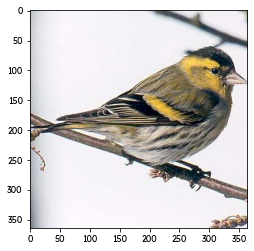

SUPERORDINATE LABEL 	: animal | 85.625%
BASIC LABEL 		: bird | 96.25%


In [ ]:
_ = get_original_preds(15,True)

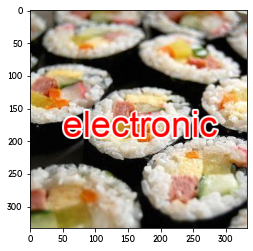

SUPERORDINATE 	 NEW 		: electronic | 98.6875%
		 ORIGINAL 	: food | 96.875% --> 0.53466796875%
----------------------------------------------------------------------------------------------------------------------------------------
BASIC 		 NEW 		: laptop | 19.375%
		 ORIGINAL 	: plate | 40.0% --> 12.3125%


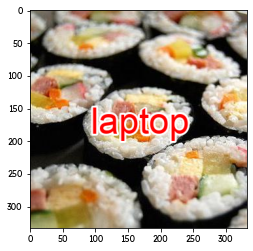

SUPERORDINATE 	 NEW 		: food | 72.25%
		 ORIGINAL 	: food | 96.875% --> 72.25%
----------------------------------------------------------------------------------------------------------------------------------------
BASIC 		 NEW 		: laptop | 93.0%
		 ORIGINAL 	: plate | 40.0% --> 2.990234375%


In [ ]:
_= get_wordAdd_preds(173, "electronic", True)
_= get_wordAdd_preds(173, "laptop", True)

### **MISCLASSIFICATION RATE**

In [ ]:
print(EWA)

{'Superordinate': {'Superordinate': 0.9273390842733908, 'Basic': 0.2826735574617721}, 'Basic': {'Superordinate': 0.4117451891174519, 'Basic': 0.7394107304598008}}


### **SEMANTIC SIMILARITY (OAC, NAC)**

In [ ]:
REF,OAC,NAC = REF_nonswitch_semantic,OAC_semantic,NAC_semantic
testCategory = "SEMANTIC SIMILARITY"

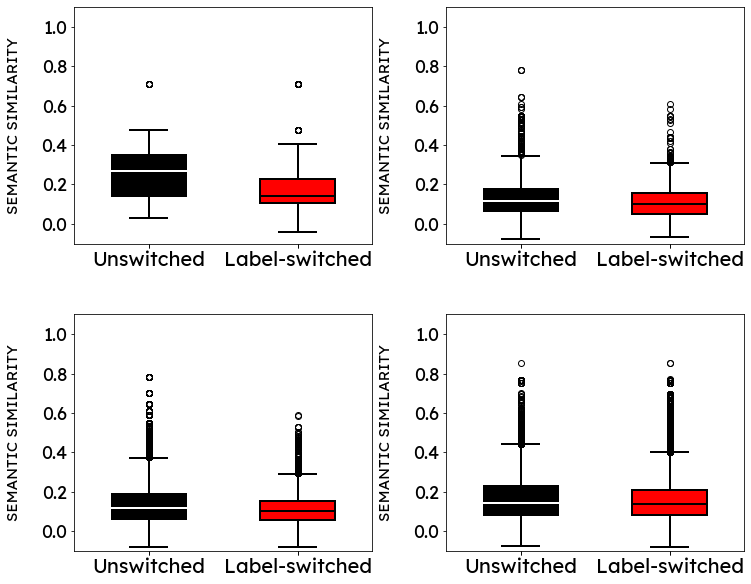

In [ ]:
display_test_boxplots_twoconds(REF,OAC,testCategory,["Unswitched","Label-switched"])

### **SPELLING SIMILARITY (OAC, NAC)**

In [ ]:
REF,OAC,NAC = REF_nonswitch_spelling,OAC_spelling,NAC_spelling
testCategory = "SPELLING SIMILARITY"

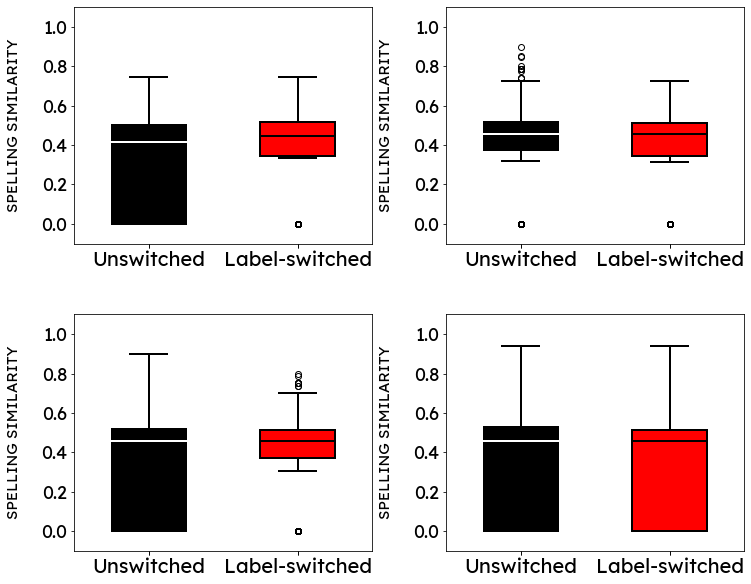

In [ ]:
display_test_boxplots_twoconds(REF,OAC,testCategory,["Unswitched","Label-switched"])

### **PROBABILITIES OF PREDICTIONS**

In [ ]:
REF, OAC, OACNew, NAC = REF_nonswitch_proba, COM_original, COM_neworiginal, COM_new 
testCategory = "PROBABILITY"

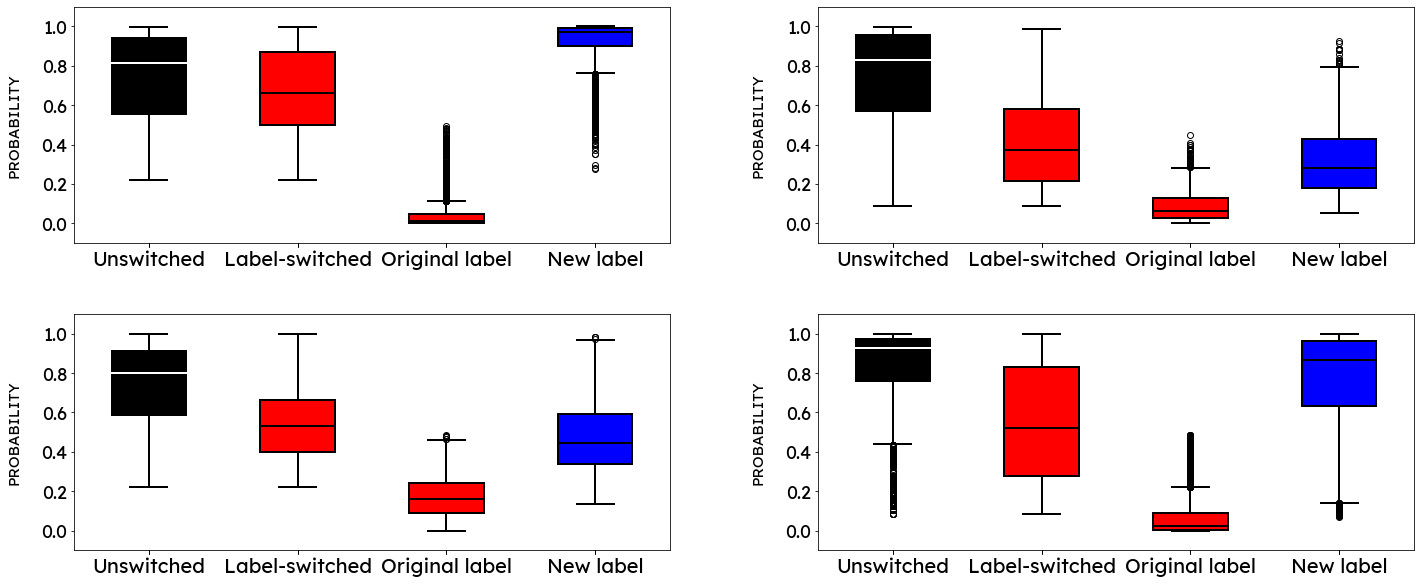

In [ ]:
display_test_boxplots_fourconds(REF,OAC,OACNew,NAC,testCategory,["Unswitched","Label-switched","Original label","New label"])

# **Representational similarity analysis**


##**UTILS**

###**ORDER STIMULIS BY LABELS**

In [ ]:
# ----- ORDERS STIMULIS A TO B BY THEIR PREDICTED LABEL (IN LABELS)
# ----- RETURNS ORDERED STIMULIS AND A LIST OF INDEXES 
def order_stimulis_by_labels(labels,a,b):
  ordered_stimulis = {}
  for label in labels:
    ordered_stimulis[label] = []
    for i in range(a,b):
      data                      = get_original_preds(i,original_predictions,display=False)
      pred_super, pred_basic    = data["Superordinate"]["Prediction"], data["Basic"]["Prediction"]
      label_super, label_basic  = super_labels[pred_super], basic_labels[pred_basic]
      if   label_super == label : ordered_stimulis[label].append(i)
      elif label_basic == label : ordered_stimulis[label].append(i)

  return ordered_stimulis

In [ ]:
def order_words_by_labels(labels,metric):
  ordered_words = {}

  features       =  model.encode_text(clip.tokenize(labels).to(device))
  basic_features =  model.encode_text(clip.tokenize(basic_labels).to(device))

  for label in labels:
    ordered_words[label] = []

  for basic_label in basic_labels:

    max_sim, closest_label = 0, ""
    for label in labels:
      sim = metric(basic_label,label)
      if sim > max_sim :
        max_sim       = sim
        closest_label = label
      
    ordered_words[closest_label].append(basic_label)

  return ordered_words

###**DISPLAY ORDERED STIMULIS**

In [ ]:
def get_ticks_and_labels(ordered_stimulis):

  labels = list(ordered_stimulis.keys())

  # GET DELIMITATION TICKS
  ticks = []
  for label in ordered_stimulis:
    if len(ticks) > 0 :
      ticks.append(ticks[len(ticks)-1] + len(ordered_stimulis[label]) )
    else :
      ticks.append(0)

      if len(ordered_stimulis[label])-1 > 0:
        ticks.append(len(ordered_stimulis[label])-1)

  # GET CENTER TICKS
  centers = []
  for i in range(len(ticks)-1): centers.append(math.floor((ticks[i] + ticks[i+1])/2)) 

  if len(centers) == len(labels)-1:
    centers.append(centers[len(centers)-1] + 1)

  # SET LABELS
  centerLabels = labels
  tickLabels  = [""] * len(ticks)

  # CORRECT CENTERS
  
  remove_centers = []
  for i in range(len(centers)):
    if ticks[i] == centers[i] : remove_centers.append(i)

  for i in range(len(centers)-1,-1,-1):
    if i in remove_centers :
      centers.pop(i)
      tickLabels[i] = centerLabels[i]
      centerLabels.pop(i)
  

  return ticks, centers, tickLabels, centerLabels

In [ ]:
def display_img_with_ordered_labels(img, ordered_labels_x, ordered_labels_y, colorbar=False, size=(5,5), ratio=(1,1), min=0, max=1, xlabel="", ylabel="", title="", title_cbar=""):
  
  x_ticks, x_centers, x_tickLabels, x_centerLabels = get_ticks_and_labels(ordered_labels_x)
  if None is ordered_labels_y : y_ticks, y_centers, y_tickLabels, y_centerLabels = x_ticks, x_centers, x_tickLabels, x_centerLabels
  else : y_ticks, y_centers, y_tickLabels, y_centerLabels = get_ticks_and_labels(ordered_labels_y)

  # --- DISPLAY IMAGE ---
  fig, ax = plt.subplots(1, 1, figsize=size)
  hm      = ax.imshow(img, cmap='Spectral', interpolation='nearest',vmin=min,vmax=max)
  ax.set_aspect(float(ratio[0]) / float(ratio[1]))
  if colorbar:
    cbar = fig.colorbar(hm)
    cbar.set_label(title_cbar,rotation=270,labelpad=30)

  ax.set_xticks(      x_centers,      minor=True)
  ax.set_xticklabels( x_centerLabels, minor=True,   rotation=90)
  ax.set_xticks(      x_ticks,        minor=False)
  ax.set_xticklabels( x_tickLabels,   minor=False,  rotation=90)
  ax.set_yticks(      y_centers,      minor=True)
  ax.set_yticklabels( y_centerLabels, minor=True,   rotation=0)
  ax.set_yticks(      y_ticks,        minor=False)
  ax.set_yticklabels( y_tickLabels,   minor=False,  rotation=0)
  ax.tick_params(axis=u'both', which=u'minor',length=0)
  ax.tick_params(axis=u'both', which=u'major',length=10)
  ax.set_xlabel(xlabel, labelpad=30, fontsize=18)
  ax.set_ylabel(ylabel, labelpad=30, fontsize=18)
  ax.set_title(title)


##**REPRESENTATIONS FOR FEEDFORWARD MODELS**

In [ ]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([transforms.Resize(256), transforms.ToTensor(), normalize])


In [ ]:
import torchvision.models as models

vgg19_bn         = models.vgg19_bn(pretrained=True)
resnet152        = models.resnet18(pretrained=True)

models = {
    "VGG19 - Batch Normalization": vgg19_bn,
    "ResNet152":                   resnet152
}

In [ ]:
reps = None
def hook_fn(module, input, output):
    global reps
    reps = input[0]

In [ ]:
images = torch.cat([preprocess(Image.fromarray(s_156['visual_stimuli156'][0][i][0])).unsqueeze(0) for i in range(156)]).to(device)

In [ ]:
def get_RDM(model, images):

  if   hasattr(model, 'classifier') : hook = model.classifier[-1].register_forward_hook(hook_fn)
  elif hasattr(model, 'fc') :         hook = model.fc.register_forward_hook(hook_fn)
  else: assert(False)

  model.to(device)
  model.eval()
  with torch.no_grad():
    _ = model(images)

  similarities = []

  for i in range(reps.size(0)):
    similarities.append([])
    for j in range(reps.size(0)):
          similarities[len(similarities)-1].append( torch.nn.CosineSimilarity(dim=0)(reps[i],reps[j]).item() )

  return similarities

VGG19 - Batch Normalization


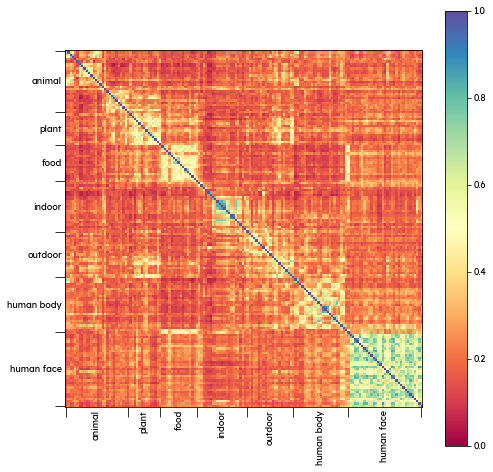

ResNet152


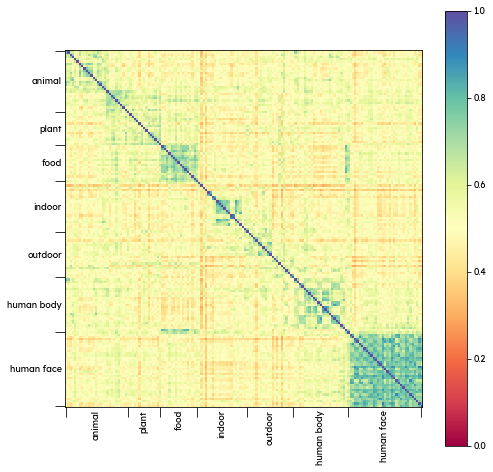

In [ ]:
for key in models :
  print(key)
  similarities = get_RDM(models[key], images)
  ordered_labels = {"animal":[None]*28, "plant":[None]*14, "food":[None]*16,"indoor":[None]*22,"outdoor":[None]*20,"human body":[None]*24,"human face":[None]*32}
  display_img_with_ordered_labels(similarities, ordered_labels, None, True, (8,8))
  plt.show()

##**REPRESENTATIONS CLIP**

In [ ]:
similarities = []
features = torch.empty(0,512).to(device)

dataset_size = 156
batch_size   = 32

#images = torch.cat([preprocess(Image.fromarray(s_92['visual_stimuli'][0][i][5])).unsqueeze(0) for i in range(92)]).to(device)
#images = torch.cat([preprocess(Image.fromarray(s_156['visual_stimuli156'][0][i][0])).unsqueeze(0) for i in range(156)]).to(device)

print(images.size())

with torch.no_grad():
  features = model.encode_image(images)

  print(features.size())

for i in range(features.size(0)):
  similarities.append([])
  for j in range(features.size(0)):
        similarities[len(similarities)-1].append( torch.nn.CosineSimilarity(dim=0)(features[i],features[j]).item() )

torch.Size([156, 3, 224, 224])
torch.Size([156, 1024])


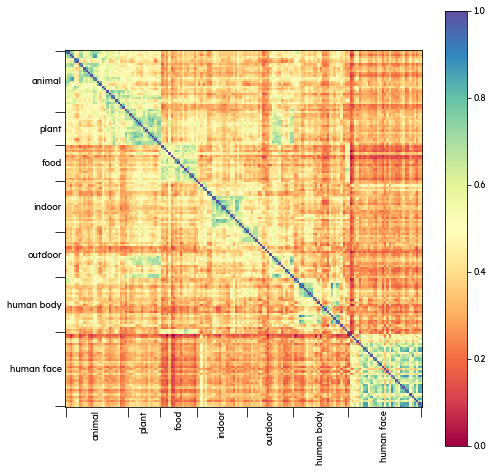

In [ ]:
ordered_labels = {"animal":[None]*28, "plant":[None]*14, "food":[None]*16,"indoor":[None]*22,"outdoor":[None]*20,"human body":[None]*24,"human face":[None]*32}
display_img_with_ordered_labels(similarities, ordered_labels, None, True, (8,8))

In [ ]:
  data_path    = path+"/DATA/"+model_name+"_"+"context"+str(contexts.index(context))+"_wordsAdd_preds.pt"
  dataset_size = 156
  words        = list(set(super_labels) | set(basic_labels))
  print(len(words))
    # ----- CHECKING IF DATA ALREADY EXISTS -------------------------------------------
  if os.path.exists(data_path): wordsAdd_predictions = torch.load(data_path,map_location=device)
  else:                         wordsAdd_predictions = {}
  start = len(wordsAdd_predictions.keys())  # Start at where we're at
  #word = 'electronic'
  #word = 'vehicle'
  #word = 'outdoor'
  #word = 'indoor'
  #word = 'accessory'
  #word = 'sports'
  #word = 'kitchen'
  #word = 'food'
  #word = 'furniture'
  #word = 'appliance'
  word = 'animal'
  #word = 'person'
  wordsAdd_predictions[word] = []
  clear_output()
  print(word)

  images = []
  for i in range(len(s_156['visual_stimuli156'][0])):
    images.append(s_156['visual_stimuli156'][0][i][0])
  #images = get_stimulis(0,156,preprocess,word=None).to(device)
  images = get_stimulis(0,156,preprocess,word=word).to(device)

animal


In [ ]:
similarities = []
features = torch.empty(0,512).to(device)

dataset_size = 156
batch_size   = 32

print(images.size())

with torch.no_grad():
  features = model.encode_image(images)

  print(features.size())

for i in range(features.size(0)):
  similarities.append([])
  for j in range(features.size(0)):
        similarities[len(similarities)-1].append( torch.nn.CosineSimilarity(dim=0)(features[i],features[j]).item() )

torch.Size([156, 3, 224, 224])
torch.Size([156, 1024])


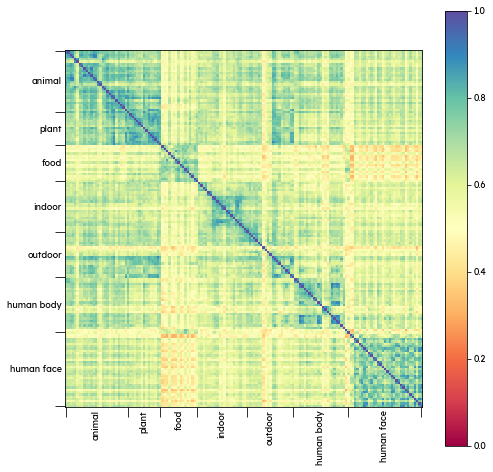

In [ ]:
ordered_labels = {"animal":[None]*28, "plant":[None]*14, "food":[None]*16,"indoor":[None]*22,"outdoor":[None]*20,"human body":[None]*24,"human face":[None]*32}
display_img_with_ordered_labels(similarities, ordered_labels, None, True, (8,8))